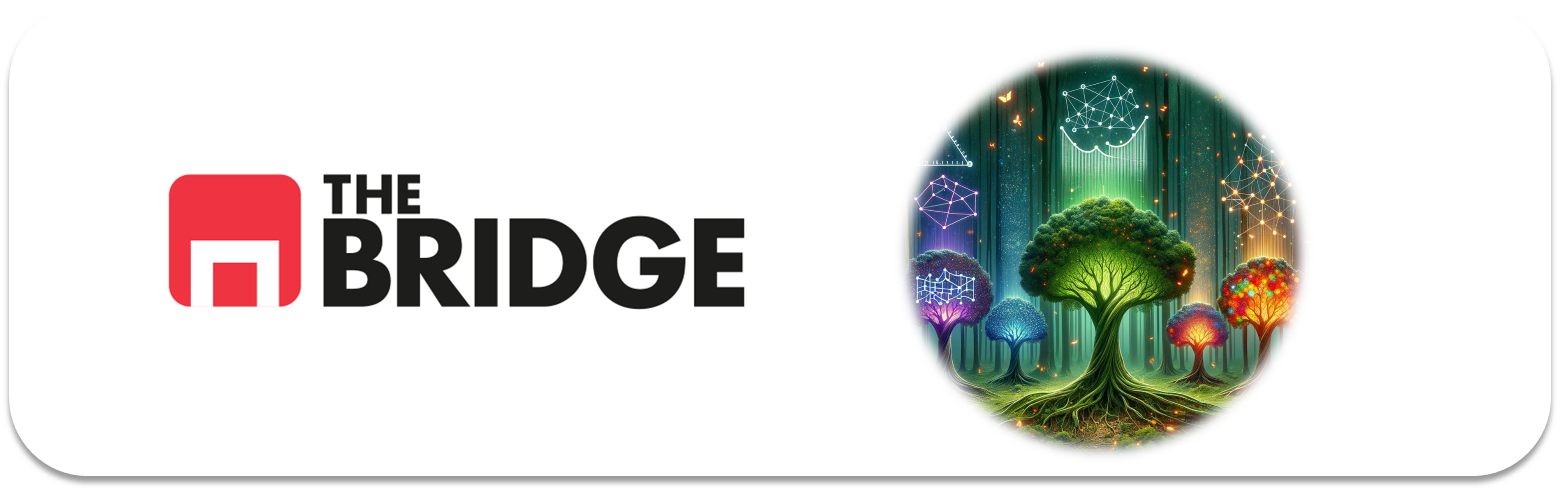

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

plt.rc('font', size=14)  
plt.rc('axes', labelsize=14, titlesize=14)  
plt.rc('legend', fontsize=14)  
plt.rc('xtick', labelsize=10)  
plt.rc('ytick', labelsize=10)  

from bootcampviztools import pinta_distribucion_categoricas, plot_categorical_relationship_fin, plot_categorical_numerical_relationship, plot_combined_graphs, plot_grouped_boxplots, plot_grouped_histograms, grafico_dispersion_con_correlacion, bubble_plot


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

### intro

In [107]:
df = pd.read_csv("./data/bank-full.csv", sep=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [108]:
df.replace("unknown", np.NaN, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   8252 non-null   object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [109]:
# poutcome es casi entera nula, fuera
df.drop(columns=["poutcome"], inplace=True)

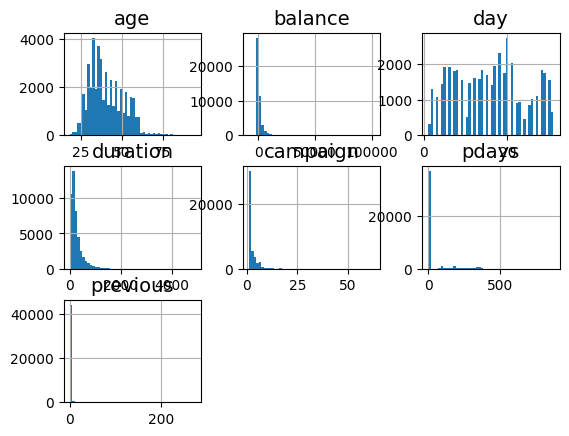

In [110]:
df.hist(bins=50)
plt.show()

In [111]:
target = "y"

In [112]:
train, test = train_test_split(df, test_size=.2, random_state=42)

- clasificacion binaria supervisada
- columnas con nulos = ["job", "education", "contact"]

### mini eda

In [113]:

cat_col = df.select_dtypes(include='object').columns.tolist()
num_col = df.select_dtypes(exclude='object').columns.tolist()

print("Variables Categóricas:", cat_col)
print("Variables Numéricas:", num_col)


Variables Categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Variables Numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


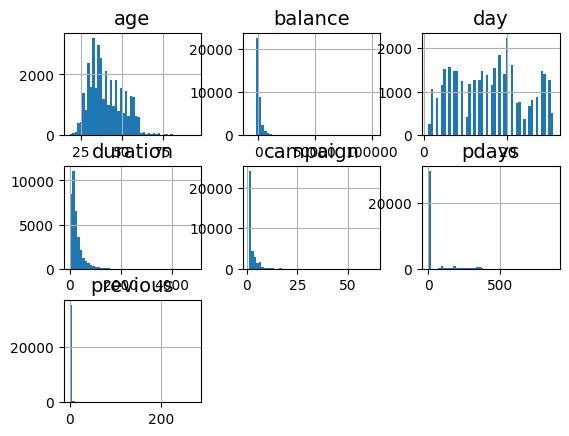

In [114]:
train.hist(bins=50)
plt.show()

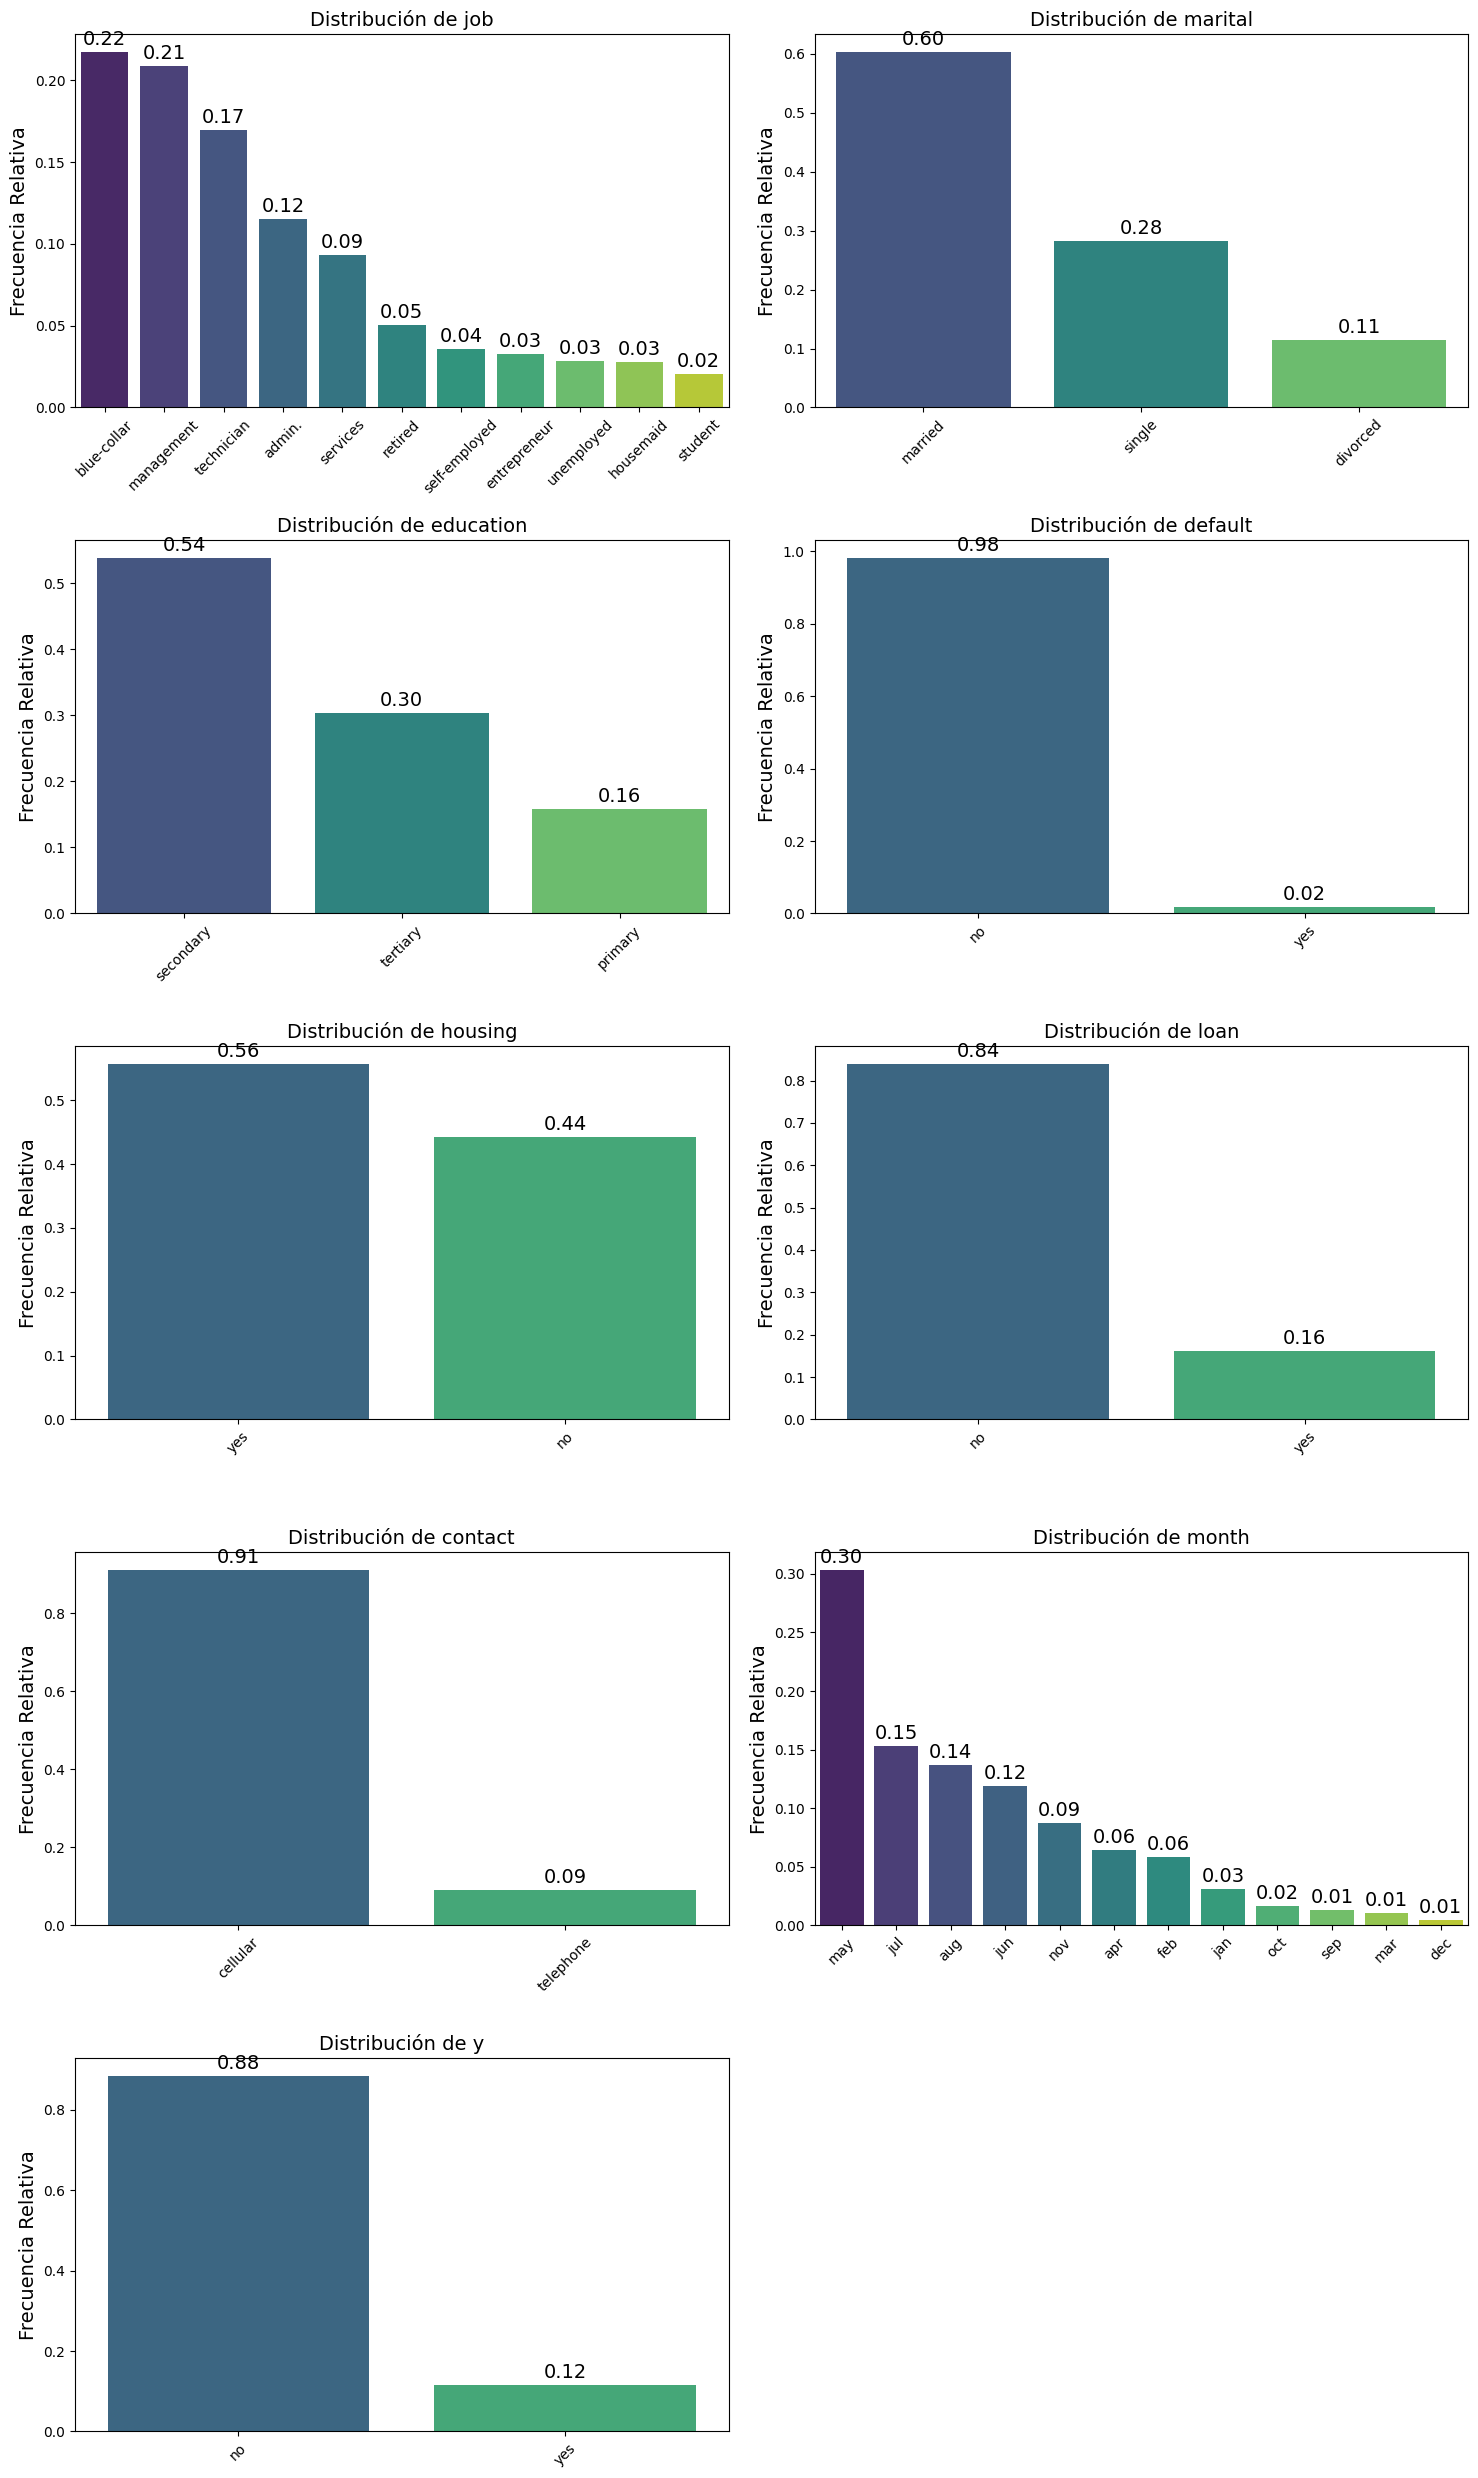

In [115]:
pinta_distribucion_categoricas(train, cat_col, relativa=True, mostrar_valores=True)

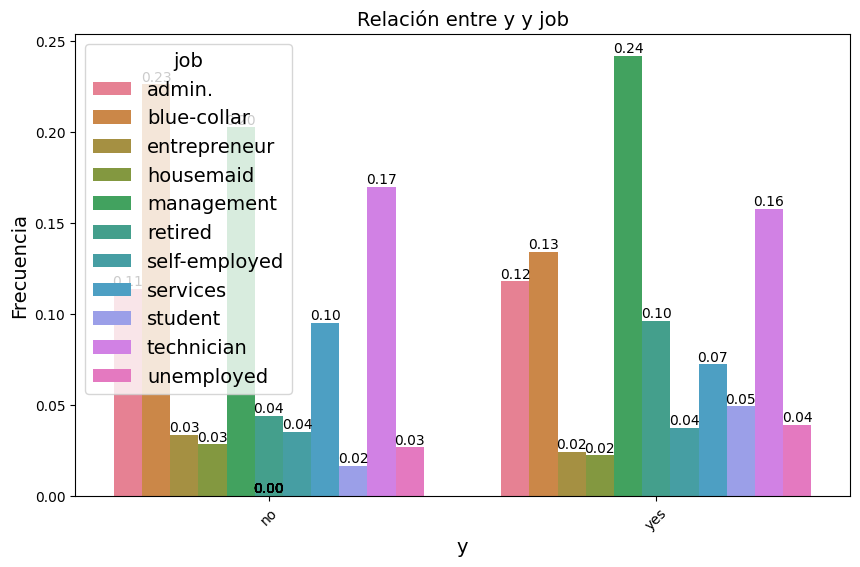

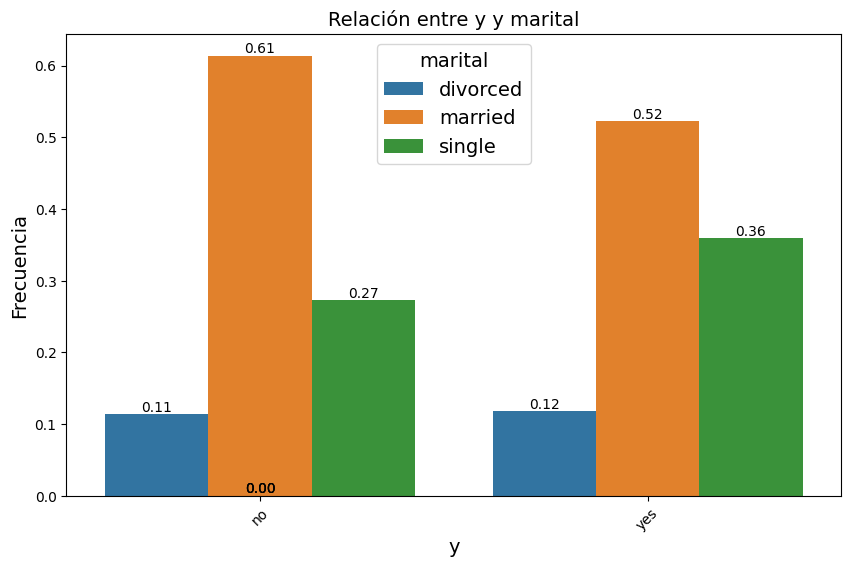

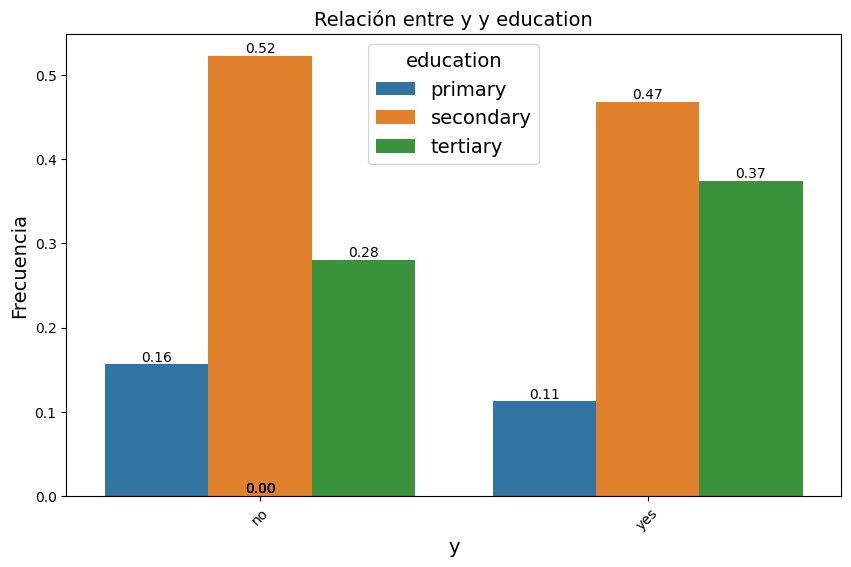

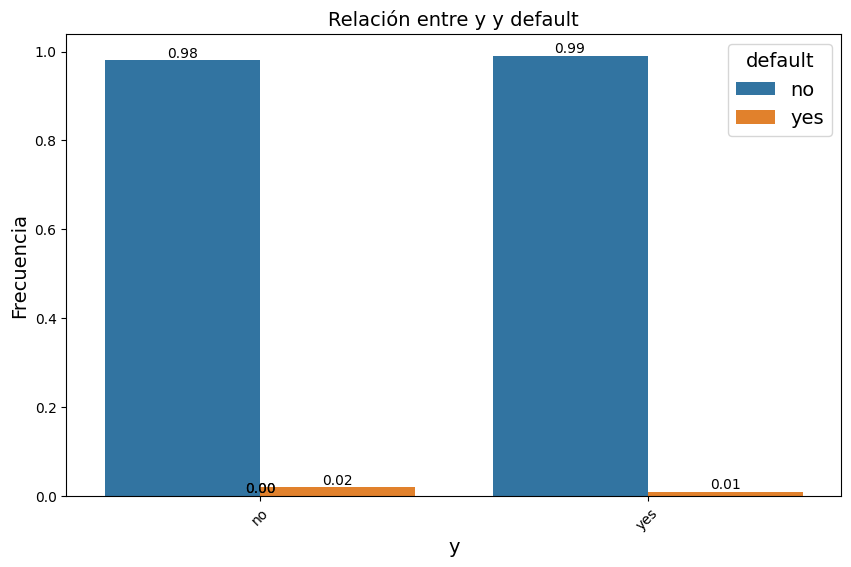

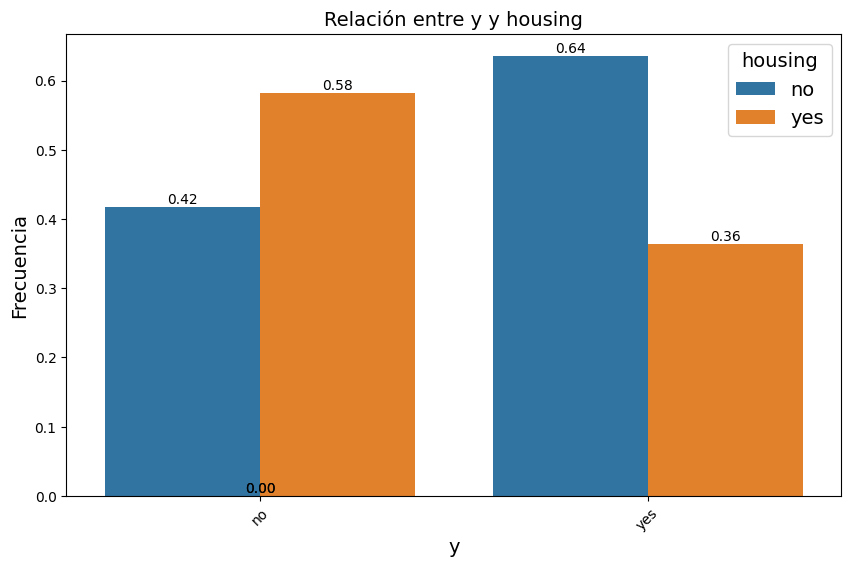

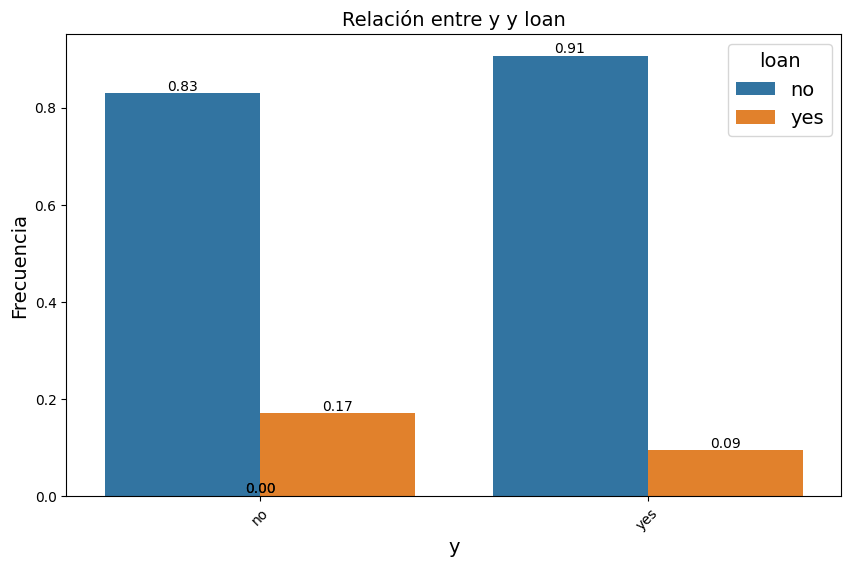

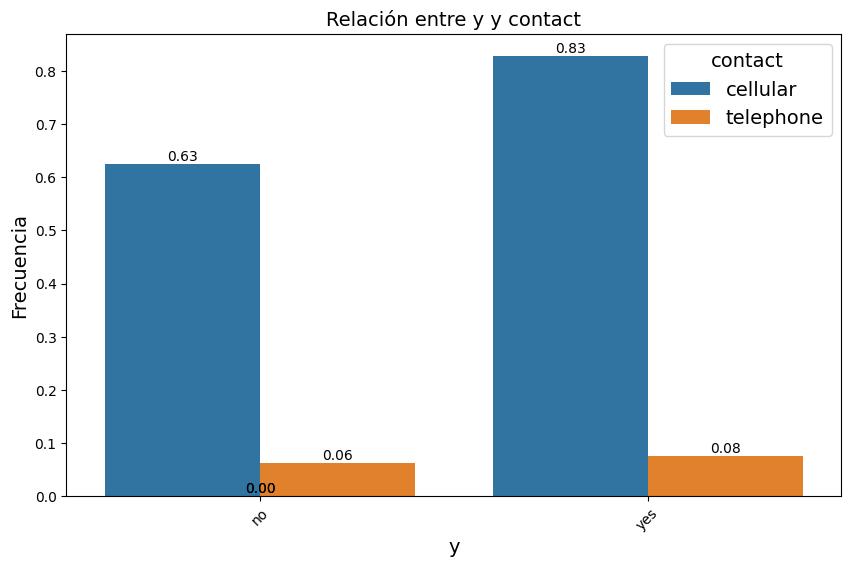

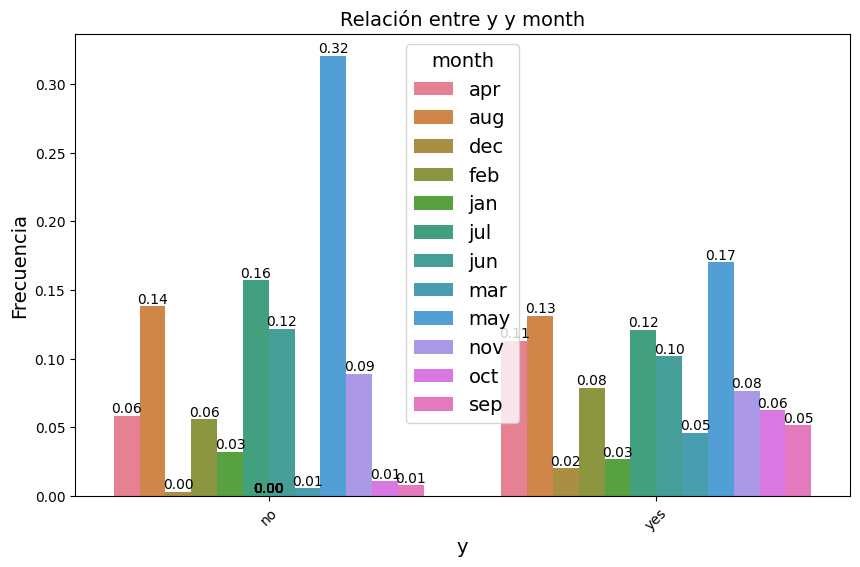

In [116]:
for col in cat_col:
    if col !=target:
          plot_categorical_relationship_fin(train, target, col, relative_freq=True, show_values=True)

- heavy tail: balance, duration, campaign, pdays, previous
- problema unbalanced
- la unica categorica crucial es housing
- default son la misma distribucion para yes y no, fuera
- todas las numericas estan completamente superpuestas

### data prep

In [117]:
train.drop(columns=["default"], inplace=True)
cat_col.remove("default")

In [118]:
train.dropna(subset=["job"], inplace=True)

In [119]:
train.dropna(subset=["education"], inplace=True)

In [120]:
train.drop(columns=["contact"], inplace=True)
cat_col.remove("contact")

In [121]:
train_backup = train.copy()

In [122]:
train = train_backup

In [123]:
train = pd.get_dummies(train, columns=["job", "marital"], dtype=int)

In [124]:
categories = [["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]]
ordinal = OrdinalEncoder(categories=categories)

train["month"] = ordinal.fit_transform(train[["month"]])

In [125]:
edu = [["primary", "secondary", "tertiary"]]
cursos = OrdinalEncoder(categories=edu)

train["education"] = cursos.fit_transform(train[["education"]])

In [126]:
train.replace("yes", 1, inplace=True)
train.replace("no", 0, inplace=True)

In [142]:
train

,age,education,balance,housing,loan,day,month,duration,campaign,pdays,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
3344,41,0.0,2.906936,1,0,15,4.0,2.901913,2.901429,2.901415,...,0,0,0,0,0,0,0,0,1,0
17965,49,0.0,2.910311,1,0,30,6.0,2.903233,2.901436,2.901415,...,0,0,0,0,0,1,0,0,1,0
18299,42,1.0,2.922702,0,0,31,6.0,2.902305,2.901450,2.901415,...,0,0,0,0,0,0,0,0,1,0
10221,37,2.0,2.900600,1,0,11,5.0,2.903930,2.901497,2.901415,...,1,0,0,0,0,0,0,0,0,1
32192,56,0.0,2.921118,0,0,15,3.0,2.903200,2.901436,2.901415,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,0.0,2.908214,0,0,18,5.0,2.914084,2.901429,2.901415,...,0,0,0,0,0,0,0,0,0,1
44732,23,2.0,2.904791,0,0,8,8.0,2.902841,2.901429,2.902049,...,0,0,0,0,1,0,0,0,0,1
38158,34,2.0,2.909743,1,0,15,4.0,2.903034,2.901429,2.901415,...,0,0,0,0,0,1,0,1,0,0
860,33,1.0,2.902541,0,0,7,4.0,2.902177,2.901429,2.901415,...,0,1,0,0,0,0,0,0,1,0


In [143]:
# heavy tail: balance, duration, campaign, pdays, previous

heavy_tail = ["balance", "duration", "campaign", "pdays", "previous"]

sumar = abs(train[heavy_tail].describe().loc["min"].values.min()) + 0.0001

for col in heavy_tail:
    train[col] = np.log(train[col]+sumar)

# estandarizar
std_scaler = StandardScaler()

train[num_col] = std_scaler.fit_transform(train[num_col])

In [144]:
train

,age,education,balance,housing,loan,day,month,duration,campaign,pdays,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
3344,0.023846,0.0,0.003499,1,0,-0.098450,4.0,-0.746497,-0.570570,-0.413891,...,0,0,0,0,0,0,0,0,1,0
17965,0.784013,0.0,0.007921,1,0,1.706506,6.0,0.065066,-0.246152,-0.413891,...,0,0,0,0,0,1,0,0,1,0
18299,0.118867,1.0,0.024144,0,0,1.826836,6.0,-0.505404,0.402556,-0.413891,...,0,0,0,0,0,0,0,0,1,0
10221,-0.356237,2.0,-0.004805,1,0,-0.579772,5.0,0.493331,2.671683,-0.413891,...,1,0,0,0,0,0,0,0,0,1
32192,1.449159,0.0,0.022071,0,0,-0.098450,3.0,0.044722,-0.246152,-0.413891,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.308909,0.0,0.005174,0,0,0.262541,5.0,6.731529,-0.570570,-0.413891,...,0,0,0,0,0,0,0,0,0,1
44732,-1.686530,2.0,0.000689,0,0,-0.940763,8.0,-0.175828,-0.570570,0.527043,...,0,0,0,0,1,0,0,0,0,1
38158,-0.641300,2.0,0.007176,1,0,-0.098450,4.0,-0.057195,-0.570570,-0.413891,...,0,0,0,0,0,1,0,1,0,0
860,-0.736321,1.0,-0.002262,0,0,-1.061093,4.0,-0.584182,-0.570570,-0.413891,...,0,1,0,0,0,0,0,0,1,0


limpieza
- drop default
- dropna job
- drop contact

transformacion
- dummies: job, marital
- ordinal: education, month
- binario: housing, loan, y

In [131]:
train

,age,education,balance,housing,loan,day,month,duration,campaign,pdays,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
3344,41,0.0,9.090205,1,0,15,4.0,8.998508,8.989694,8.989444,...,0,0,0,0,0,0,0,0,1,0
17965,49,0.0,9.152075,1,0,30,6.0,9.022564,8.989818,8.989444,...,0,0,0,0,0,1,0,0,1,0
18299,42,1.0,9.381011,0,0,31,6.0,9.005651,8.990068,8.989444,...,0,0,0,0,0,0,0,0,1,0
10221,37,2.0,8.974618,1,0,11,5.0,9.035272,8.990940,8.989444,...,1,0,0,0,0,0,0,0,0,1
32192,56,0.0,9.351579,0,0,15,3.0,9.021961,8.989818,8.989444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,0.0,9.113609,0,0,18,5.0,9.221478,8.989694,8.989444,...,0,0,0,0,0,0,0,0,0,1
44732,23,2.0,9.050993,0,0,8,8.0,9.015420,8.989694,9.000976,...,0,0,0,0,1,0,0,0,0,1
38158,34,2.0,9.141633,1,0,15,4.0,9.018938,8.989694,8.989444,...,0,0,0,0,0,1,0,1,0,0
860,33,1.0,9.009936,0,0,7,4.0,9.003316,8.989694,8.989444,...,0,1,0,0,0,0,0,0,1,0


lo dejo aqui llevo muchisimo tiempo con esta practica y ni siquiera he llegado al objetivo principal

In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34548 entries, 3344 to 15795
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                34548 non-null  int64  
 1   education          34548 non-null  float64
 2   balance            34548 non-null  float64
 3   housing            34548 non-null  int64  
 4   loan               34548 non-null  int64  
 5   day                34548 non-null  int64  
 6   month              34548 non-null  float64
 7   duration           34548 non-null  float64
 8   campaign           34548 non-null  float64
 9   pdays              34548 non-null  float64
 10  previous           34548 non-null  float64
 11  y                  34548 non-null  int64  
 12  job_admin.         34548 non-null  int32  
 13  job_blue-collar    34548 non-null  int32  
 14  job_entrepreneur   34548 non-null  int32  
 15  job_housemaid      34548 non-null  int32  
 16  job_management     34548

### test
limpieza
- drop default
- dropna job
- drop contact

transformacion
- dummies: job, marital
- ordinal: education, month
- binario: housing, loan, y

In [133]:
test.drop(columns=["default"], inplace=True)
test.dropna(subset=["job"], inplace=True)
test.dropna(subset=["education"], inplace=True)
test.drop(columns=["contact"], inplace=True)
test = pd.get_dummies(test, columns=["job", "marital"], dtype=int)
categories = [["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]]
ordinal = OrdinalEncoder(categories=categories)
test["month"] = ordinal.fit_transform(test[["month"]])
edu = [["primary", "secondary", "tertiary"]]
cursos = OrdinalEncoder(categories=edu)
test["education"] = cursos.fit_transform(test[["education"]])
test.replace("yes", 1, inplace=True)
test.replace("no", 0, inplace=True)

In [ ]:
# heavy tail: balance, duration, campaign, pdays, previous

heavy_tail = ["balance", "duration", "campaign", "pdays", "previous"]

sumar = abs(test[heavy_tail].describe().loc["min"].values.min()) + 0.0001

for col in heavy_tail:
    test[col] = np.log(test[col]+sumar)

# estandarizar

test[num_col] = std_scaler.fit_transform(test[num_col])

In [134]:
test

,age,education,balance,housing,loan,day,month,duration,campaign,pdays,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
3776,40,1.0,580,1,0,16,4.0,192,1,-1,...,0,0,0,0,0,0,0,0,1,0
9928,47,1.0,3644,0,0,9,5.0,83,2,-1,...,0,0,0,1,0,0,0,0,0,1
33409,25,2.0,538,1,0,20,3.0,226,1,-1,...,0,0,0,0,1,0,0,0,0,1
31885,42,2.0,1773,0,0,9,3.0,311,1,336,...,1,0,0,0,0,0,0,0,1,0
15738,56,2.0,217,0,1,21,6.0,121,2,-1,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13353,47,2.0,1890,0,0,8,6.0,161,1,-1,...,1,0,0,0,0,0,0,0,1,0
38732,32,1.0,217,1,0,15,4.0,692,3,-1,...,0,0,0,0,0,0,0,0,0,1
5654,52,1.0,0,1,0,26,4.0,206,1,-1,...,0,0,0,0,0,0,0,1,0,0
3779,40,1.0,783,1,1,16,4.0,171,2,-1,...,0,0,0,0,0,0,0,1,0,0


### modelo

In [135]:
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

#### baseline

In [136]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

pred_train_tree = tree.predict(X_train)
pred_test_tree = tree.predict(X_test)

print(classification_report(y_true=y_train, y_pred=pred_train_tree))
print(classification_report(y_true=y_test, y_pred=pred_test_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30552
           1       1.00      1.00      1.00      3996

    accuracy                           1.00     34548
   macro avg       1.00      1.00      1.00     34548
weighted avg       1.00      1.00      1.00     34548

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7620
           1       0.08      0.08      0.08      1025

    accuracy                           0.79      8645
   macro avg       0.48      0.48      0.48      8645
weighted avg       0.78      0.79      0.78      8645



#### random search

In [137]:
tree_param_grid = {
    'max_depth': [None] + list(range(1, 11)),
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [2,4,8]
}

tree = DecisionTreeClassifier()
randomized_tree = RandomizedSearchCV(tree, tree_param_grid, n_iter=25, scoring="accuracy", random_state=42)

randomized_tree.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=25,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 4, 8]},
                   random_state=42, scoring='accuracy')

In [138]:
randomized_tree.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=8, min_samples_split=4)

In [139]:
randomized_train_pred = randomized_tree.best_estimator_.predict(X_train)
randomized_test_pred = randomized_tree.best_estimator_.predict(X_test)

print(classification_report(y_train, randomized_train_pred))
print(classification_report(y_test, randomized_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     30552
           1       0.66      0.44      0.53      3996

    accuracy                           0.91     34548
   macro avg       0.79      0.71      0.74     34548
weighted avg       0.90      0.91      0.90     34548

              precision    recall  f1-score   support

           0       0.89      0.63      0.74      7620
           1       0.14      0.43      0.21      1025

    accuracy                           0.61      8645
   macro avg       0.51      0.53      0.47      8645
weighted avg       0.80      0.61      0.67      8645



Fatal, se escapan un monton los positivos pero mucho mejor que el train